# Experiments with GNN's

In [96]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from matplotlib import pyplot as plt

## 02 utility functions

In [97]:
def print_graph_info(graph):
  print("Directed graph:", graph.is_directed())
  print("Number of nodes:", graph.number_of_nodes())
  print("Number of edges:", graph.number_of_edges())

In [98]:
def get_colors_for_infection_status(infection_status):
    colors = []
    for _, i in infection_status.items():
        if i == 0: colors.append("blue")
        elif i == 1: colors.append("red")
        elif i == 2: colors.append("gray")
    return colors

In [99]:
def plot_graph_with_status(g, status):
    colors = get_colors_for_infection_status(status)
    seed = 31
    pos = nx.spring_layout(g, seed=seed)
    plt.figure(figsize=(6,4))
    nx.draw(g, pos=pos, with_labels=True, node_color = colors, node_size = 250)

## create graph with networkx

Directed graph: True
Number of nodes: 4
Number of edges: 5


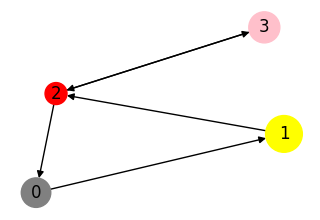

In [100]:
H = nx.DiGraph()

H.add_nodes_from([
  (0, {"color": "gray", "size": 450}),
  (1, {"color": "yellow", "size": 700}),
  (2, {"color": "red", "size": 250}),
  (3, {"color": "pink", "size": 500})
])

H.add_edges_from([
  (0, 1),
  (1, 2),
  (2, 0),
  (2, 3),
  (3, 2)
])

print_graph_info(H)

node_colors = nx.get_node_attributes(H, "color").values()
colors = list(node_colors)
node_sizes = nx.get_node_attributes(H, "size").values()
sizes = list(node_sizes)

plt.figure(figsize=(3,2))
nx.draw(H, with_labels=True, node_color=colors, node_size=sizes)

## Simulate Graph with ND lib

In [101]:
g = nx.erdos_renyi_graph(40, 0.1, seed = 123)
model = ep.SIRModel(g)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.006)
config.add_model_parameter('gamma', 0.01)
config.add_model_parameter("fraction_infected", 0.1)
model.set_initial_status(config)

iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

print_graph_info(g)

Directed graph: False
Number of nodes: 40
Number of edges: 90


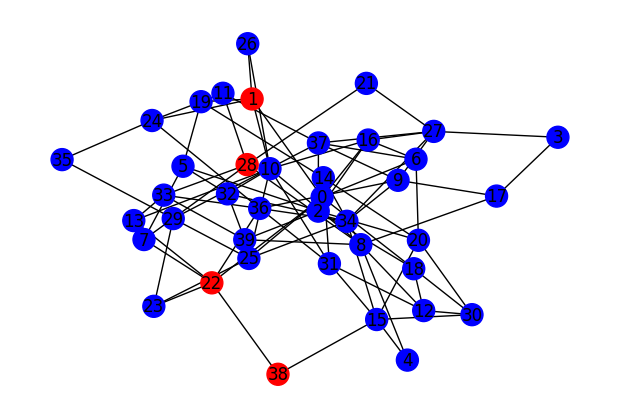

In [102]:
# graph start infection
plot_graph_with_status(g, model.initial_status)


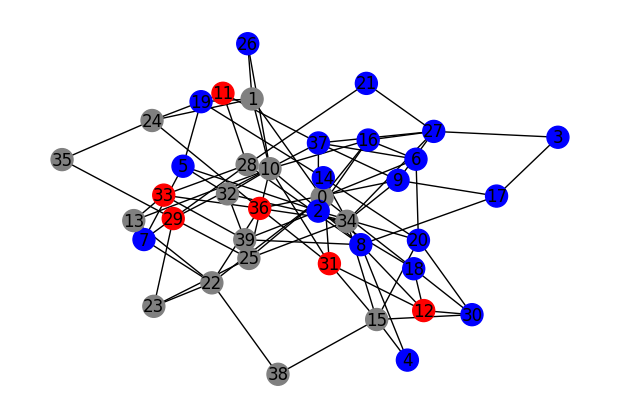

In [103]:
# graph end infection
plot_graph_with_status(g, model.status)

## Karate Club Example

In [104]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print("Dataset:", dataset)
print("# Graphs:", len(dataset))
print("# Features:", dataset.num_features)
print("# Classes:", dataset.num_classes)

Dataset: KarateClub()
# Graphs: 1
# Features: 34
# Classes: 4


In [105]:
data = dataset[0]
print(data)
print("Training nodes:", data.train_mask.sum().item())
print("Is directed:", data.is_directed())

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Training nodes: 4
Is directed: False


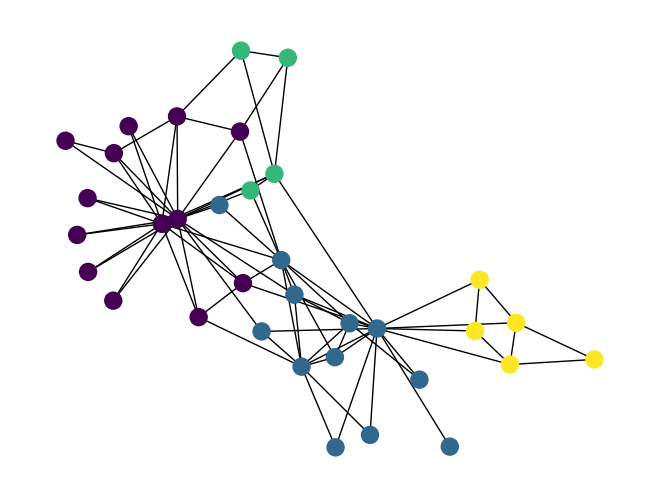

In [106]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
nx.draw(G, node_color=data.y, node_size=150)

In [107]:
import torch
from torch.nn import Linear, Module
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    torch.manual_seed(42)
    self.conv1 = GCNConv(dataset.num_features, 4)
    self.conv2 = GCNConv(4, 4)
    self.conv3 = GCNConv(4, 2)
    self.classifier = Linear(2, dataset.num_classes)
  def forward(self, x, edge_index):
    h = self.conv1(x, edge_index)
    h = h.tanh()
    h = self.conv2(h, edge_index)
    h = h.tanh()
    h = self.conv3(h, edge_index)
    h = h.tanh()
    out = self.classifier(h)
    return out, h
  
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


In [108]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
def train(data):
  optimizer.zero_grad()
  out, h = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss, h
epochs = range(1, 301)
losses = []
embeddings = []
for epoch in epochs:
  loss, h = train(data)
  losses.append(loss)
  embeddings.append(h)
  print(f"Epoch: {epoch}\tLoss: {loss:.4f}")

Epoch: 1	Loss: 1.3996
Epoch: 2	Loss: 1.3749
Epoch: 3	Loss: 1.3545
Epoch: 4	Loss: 1.3380
Epoch: 5	Loss: 1.3248
Epoch: 6	Loss: 1.3137
Epoch: 7	Loss: 1.3034
Epoch: 8	Loss: 1.2929
Epoch: 9	Loss: 1.2814
Epoch: 10	Loss: 1.2689
Epoch: 11	Loss: 1.2553
Epoch: 12	Loss: 1.2410
Epoch: 13	Loss: 1.2264
Epoch: 14	Loss: 1.2117
Epoch: 15	Loss: 1.1971
Epoch: 16	Loss: 1.1827
Epoch: 17	Loss: 1.1682
Epoch: 18	Loss: 1.1534
Epoch: 19	Loss: 1.1382
Epoch: 20	Loss: 1.1224
Epoch: 21	Loss: 1.1060
Epoch: 22	Loss: 1.0895
Epoch: 23	Loss: 1.0730
Epoch: 24	Loss: 1.0569
Epoch: 25	Loss: 1.0412
Epoch: 26	Loss: 1.0259
Epoch: 27	Loss: 1.0108
Epoch: 28	Loss: 0.9960
Epoch: 29	Loss: 0.9816
Epoch: 30	Loss: 0.9677
Epoch: 31	Loss: 0.9545
Epoch: 32	Loss: 0.9420
Epoch: 33	Loss: 0.9302
Epoch: 34	Loss: 0.9189
Epoch: 35	Loss: 0.9080
Epoch: 36	Loss: 0.8976
Epoch: 37	Loss: 0.8876
Epoch: 38	Loss: 0.8781
Epoch: 39	Loss: 0.8690
Epoch: 40	Loss: 0.8601
Epoch: 41	Loss: 0.8515
Epoch: 42	Loss: 0.8430
Epoch: 43	Loss: 0.8347
Epoch: 44	Loss: 0.82